<a href="https://colab.research.google.com/github/SeongBaek-Cho/covid19-visualization/blob/master/visualization_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid19 visualizations

In [55]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 1. Feature set

### 1-1. Data prepare

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation

import plotly.express as pex
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [57]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [58]:
pd.set_option("display.float_format", lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings('ignore')

In [59]:
patient = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/covid_eda/data/PatientInfo.csv')
patient.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.00,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released


In [60]:
print(patient.shape, len(patient.patient_id.unique()))

(3388, 18) 3388


PatientInfo 내 3,388명의 확진자가 있는것으로 보여짐

In [61]:
data = patient.copy()

### 1-2. Infection route

어떤 경로로 코로나 바이러스에 감영되었는지 보여주는 특성입니다. 사람의 행동에 따라 값이 달라지므로 행동적인 특성으로 볼 수 있습니다.

In [62]:
print('unique values count of infection caase : ',len(data['infection_case'].unique()))
data['infection_case'].unique()

unique values count of infection caase :  24


array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', 'Onchun Church',
       'Cheongdo Daenam Hospital', 'Suyeong-gu Kindergarten', nan,
       'Ministry of Oceans and Fisheries', 'gym facility in Cheonan',
       'gym facility in Sejong', 'River of Grace Community Church',
       'Gyeongsan Seorin Nursing Home',
       'Gyeongsan Cham Joeun Community Center',
       'Gyeongsan Jeil Silver Town', 'Bonghwa Pureun Nursing Home',
       'Pilgrimage to Israel', 'Milal Shelter', 'Geochang Church',
       'Changnyeong Coin Karaoke'], dtype=object)

infections_case의 값의 종류가 24개인 것을 볼 수 있습니다. 24개의 값들이 실제로 얼마나 존재하는지 높은 순으로 정렬한 다음의 차트를 보면 첫 세개의 값(환자와의 직접 접촉-'contact with patient', 해외유입-'overseas inflow', 알수없음-'etc')을 제외한 나머지 각각은 큰 비중을 차지하지 않는 것을 볼 수 있습니다.

In [63]:
def drawinfectionValues(groups, feature):
  groups = data.groupby([feature])['patient_id'].count()
  groups = groups.reset_index()
  groups = groups.rename(columns = {'patient_id':'count'})
  groups = groups.sort_values('count', ascending=False)

  plt.figure(figsize=(10,8))
  plt.title('number of patients in infection_case values')
  sns.barplot(y=feature, x='count', data=groups)
  display()


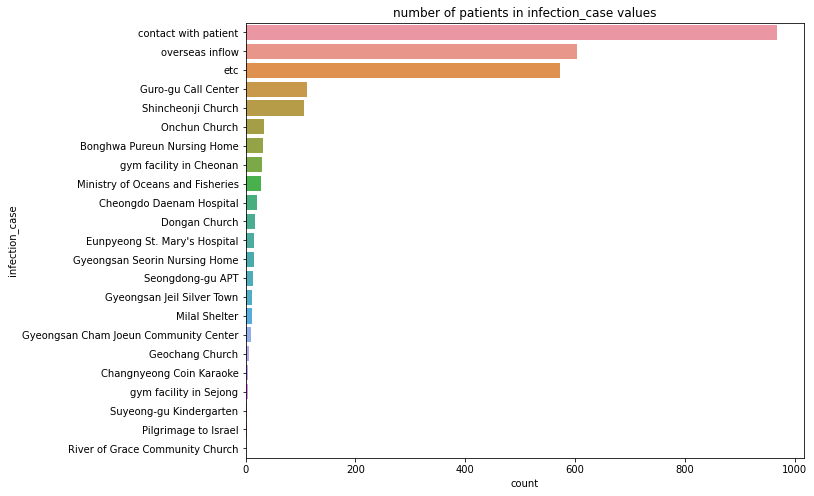

In [64]:
drawinfectionValues(data, 'infection_case')

'어디'에서 감염되었느냐를 보는 것이 분석의 목적이었다면, 모든 값의 사용을 고려하는 것이 맞을 것입니다. 하지만 이번 분석의 목적은 감염의 '어떤' 경로가 사망에 이르는 위험성을 가지고 있었느냐를 밝히는 것입니다. 그렇다면 '어디'라는 구체적 장소를 그대로 사용하는 것보다 이 변수를 활용해 '어떤' 방식으로 감염되게 되었는지를 만들어내 모델에 활용하는 것이 필요합니다. 첫 번째 세개의 값, '감염자와의 직접 접촉(contact with patient)', '해외유입(overseas inflow)', '알수없음(etc)'은 그 자체의 의미를 살려두고, 나머지는 집단 감염에 따른 세부적 사례를 나타내는 것으로 한데 묶어 '집단 감염(group)'의 값을 부여합니다.

하지만 이때 '집단 감염'을 정의하는데에는 주의를 필요로 합니다. 위의 차트를 보면 "River of Grace Community Church"는 교회에서 감염된 것으로 보아 '집단 감염'일 가능성이 있지만, 실제로 해당 값을 갖는 확진자는 단 한명에 불과합니다. 데이터 내에 한 명만이 존재하는 사례를 "집단 감염"이라고 보기는 어려울 것입니다. 마찬가지로 소수의 인원이 속한 값은 값 자체로는 집단으로 보일지 몰라도 실제로는 집단 감염이라고 보기 어렵습니다. 따라서 해당 값을 가진 확진자들의 수가 최소 5명 이상일 때에만 '집단 감염(group)' 값을 부여하고, 나머지는 활용하지 않습니다.

먼저 5명 미만의 infection_case를 추출해 확인합니다.

In [65]:
groups = data.groupby(['infection_case'])['patient_id'].count()
groups = pd.DataFrame(groups)

In [66]:
infection_case_less_5 = groups[groups['patient_id']<5].index.tolist()
groups[groups.index.isin(infection_case_less_5)]

,patient_id
infection_case,
Changnyeong Coin Karaoke,4
Pilgrimage to Israel,2
River of Grace Community Church,1
Suyeong-gu Kindergarten,3
gym facility in Sejong,4


5명 미만의 infection_case를 추출하여 14명의 확진자를 데이터에서 제거합니다.

In [67]:
print('original data shape:', data.shape)
data = data[~(data['infection_case'].isin(infection_case_less_5))]
print('removed data shape less than 5 infections :',data.shape)

original data shape: (3388, 18)
removed data shape less than 5 infections : (3374, 18)


infection_case 값에 존재하던 nan를 어떻게 처리할지를 결정합니다. 가장 간단한 방법은 nan값을 가진 확진자는 모두 제거하는 것일 겁니다. 하지만 아래 infection_csae의 nan의 수는 768개(약 23%)로 꽤 많은 비중을 차지하는 것을 볼 수 있습니다.

In [68]:
data[data['infection_case'].isna()].shape

(768, 18)

infection_case가 nan이라는 것은 그야말로 해당 확진자의 감염 경로를 "알 수 없다"는 의미이고, 해당 값은 infection_case의 값 중 하나인 etc가 의미하는 바와 같습니다. 따라서 nan은 etc와 같은 카테고리 - "알 수 없음(unknown)"으로 정의합니다.

In [69]:
def categorisation(x):
  if x == 'overseas inflow':
    y = 'overseas'
  elif x == 'contact with patient':
    y = 'individual'
  elif (x=='etc') | (pd.isna(x)):
    y = 'unknown'
  else:
    y = 'group'
  return y

In [70]:
data['infection'] = data['infection_case'].apply(lambda x: categorisation(x))
print(data.shape)
data.head()



(3374, 19)


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released,overseas
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released,individual
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.00,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released,individual


새로 가공한 변수를 대상으로 다시 그려보면, 네 가지의 값이 모두 의미있는 분포를 보이는 것을 확인할 수 있으며 결과적으로도 의미있는 결과를 도출할 것이라고 예상할 수 있습니다.

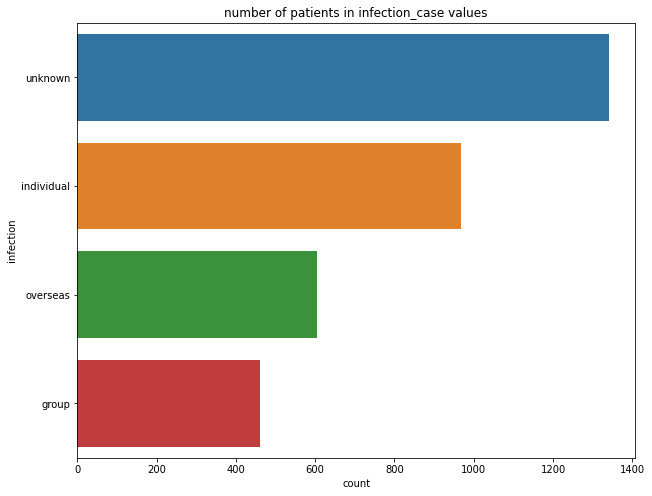

In [71]:
drawinfectionValues(groups, 'infection')

PatientInfo의 infection_case를 재가공하여 '집단감염(group)', '개인감염(individual)', '해외유입(overseas)', '밝혀지지않음(unknown)'으로 구성된 "감염 경로 유형"의 특성이 생성되었습니다.

### 1-3. Mobility level

유동성은 확진자들이 얼마만큼의 이동을 보였는지를 나타내는 특성입니다. 예를들어 친구를 만나러 카페에 간 사람과 가지 않고 집에 있던 사람은 유동성에서 다른 값을 갖게 될 것입니다. 따라서 유동성은 확진자들의 행동 유형을 구분지을 수 있는 행동적 특성의 하나로써 모델에 활용합니다. 유동성의 특성은 확진자들이 다녀갔던 장소에 대한 정보를 나타내는 PatientRoute의 type에 기반하여 생성됩니다.

In [72]:
route = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/covid_eda/data/PatientRoute.csv')
route.head()

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.00,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.62,126.72
1,1000000001,2.00,2020-01-24,Seoul,Jung-gu,hospital,37.57,127.01
2,1000000002,5.00,2020-01-25,Seoul,Seongbuk-gu,etc,37.59,127.02
3,1000000002,5.00,2020-01-26,Seoul,Seongbuk-gu,store,37.59,127.02
4,1000000002,5.00,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.56,127.03


In [73]:
print('the number of unique values in type:', len(route['type'].unique()))
route['type'].unique()

the number of unique values in type: 24


array(['airport', 'hospital', 'etc', 'store', 'public_transportation',
       'restaurant', 'church', 'beauty_salon', 'pharmacy', 'pc_cafe',
       'bank', 'cafe', 'bakery', 'bar', 'gym', 'school',
       'real_estate_agency', 'karaoke', 'post_office', 'gas_station',
       'lodging', 'academy', 'university', 'administrative_area_level_1'],
      dtype=object)

In [74]:
route[route['type'].isna()].shape

(0, 8)

먼저 데이터에는 총 24가지의 독립적인 장소들이 존재하고 있고, 해당 변수에는 결측치가 없는 것을 확인하였습니다. 이 장소들을 기반으로 각 확진자들의 '유동성'에 대한 특성을 추출합니다. 먼저 방문한 장소들을 기반으로 해당 이동이 필수적(essential)이었는지 부수적(non-essential)이었는지를 구분하고, 각 확진자 별로 필수적/부수적 이동을 얼마나 하였는지 그 횟수를 구합니다.

필수적/부수적 이동을 구별하고자 먼저 24가지의 장소들을 세부 카테고리로 구분하였습니다.

In [75]:
leisure = ['library', 'theater', 'cafe', 'bakery', 'beauty_salon',
          'pc_cafe', 'billiards','restaurant', 'bar', 'karaoke']
travel = ['airport', 'lodging']
essential_edu = ['primary_school', 'school', 'university']
non_essential_edu = ['academy']
exercise = ['gym', 'mountain', 'park']
essential_admin = ['administrative_area_level_1', 'governmnet_office', 'post_office']
non_essential_admin = ['police_office', 'bank', 'real_estate_agency']
necessity = ['store', 'public_transportation', 'gas_station']
medical = ['hospital', 'pharmacy']
church = ['church']
etc = ['etc']

위 카테고리 중에서 '필수 교육(essential_edu)/필수 행정(essential_admin)/생활 필수(necessity)/의료(medical)' 카테고리를 필수적 이동(essential)으로 구분하고, 나머지는 부수적 이동(non-essential)으로 정의합니다.

In [76]:
essential = essential_edu + essential_admin + necessity + medical

In [77]:
def type_gorup_essential(x):
  group = None
  if x in essential:
    group = 'essential'
  else:
    group = 'non-essential'
  return group

In [78]:
route['route_group_essential'] = route['type'].apply(lambda x: type_gorup_essential(x))
route = route[['patient_id','type','route_group_essential']]
route.head()

,patient_id,type,route_group_essential
0,1000000001,airport,non-essential
1,1000000001,hospital,essential
2,1000000002,etc,non-essential
3,1000000002,store,essential
4,1000000002,public_transportation,essential


In [79]:
route['route_value'] = 1
groups = pd.DataFrame(route.groupby(['patient_id','route_group_essential'])['route_value'].count().unstack())
groups

route_group_essential,essential,non-essential
patient_id,,
1000000001,1.00,1.00
1000000002,9.00,4.00
1000000003,nan,2.00
1000000004,1.00,nan
1000000005,1.00,nan
...,...,...
6100000086,2.00,2.00
6100000087,6.00,2.00
6100000088,5.00,19.00


간간이 nan의 값이 보이는 것을 볼 수 있습니다. raw data에서 type은 결측치가 없었고 위의 테이블은 이를 기반으로 essential/non-essential의 횟수를 구한 것으로, 위 테이블의 nan은 해당 확진자가 해당 이동(essential 또는 non-essential)을 하지 않았음을 의미합니다. 따라서 이 경우, nan의 값은 '이동을 하지 않았음'을 의미하는 0으로 채워줍니다.

In [80]:
groups.fillna(0, inplace=True)
groups.reset_index(inplace=True)
groups = groups[['patient_id', 'essential', 'non-essential']]
groups.head()

route_group_essential,patient_id,essential,non-essential
0,1000000001,1.00,1.00
1,1000000002,9.00,4.00
2,1000000003,0.00,2.00
3,1000000004,1.00,0.00
4,1000000005,1.00,0.00


확진자의 유동성을 나타내는 확진자별 필수/부수적 이동 횟수 테이블이 생성되었습니다. 이를 전체 데이터에 확진자별로 더해주어 모델에 활용할 수 있도록 합니다.

In [81]:
data = data.merge(groups, left_on='patient_id', right_on='patient_id', how='left')
data.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released,overseas,9.00,4.00
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released,individual,0.00,2.00
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.00,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released,individual,1.00,0.00


In [82]:
print(data.shape)
data[(data['essential'].isna()) | (data['non-essential'].isna())].shape

(3374, 21)


(2170, 21)

현재 데이터가 보유한 3374 명의 확진자들이 모두 essential/non-essential 특성을 갖고있지 않습니다. essential/non-essential의 특성을 갖지 않은 케이스는 모두 2170명으로 굉장히 많은 부분을 차지합니다. 이들이 이동을 하지 않았기 때문에 route의 데이터가 없을 것이라 가정하고, '이동하지 않았음'을 나타내는 0의 값을 줄 수 있으나, 실제로 이동을 하지 않았기 때문에 route 데이터에 존재하지 않았는지 확신할 수 없습니다. 64%에 해당하는 많은 사람들이 어떤 이동도 하지 않았다고는 단정하기 어렵습니다. 이동은 하였으나 기록하지 않은 경우가 많을거라고 생각됩니다. 이들의 값을 추정할 수 있는 데이터나 다른 근거가 더이상 없으므로 essential/non-essential 특성을 갖지 않는 데이터는 모델에 사용하지 않습니다.

In [83]:
print('original data shape : ', data.shape)
data = data[(data['essential'].notna()) & (data['non-essential'].notna())]
print('removed data shape : ', data.shape)

original data shape :  (3374, 21)
removed data shape :  (1204, 21)


essential/non-essential 유동성을 나타내는 특성이 완성되었고, 해당 특성을 가진 1204명의 확진자가 표본에 있습니다.

### 1-4. Number of contacts

유동성(1-3)과 더불어 확진자들의 행동 유형을 파악할 수 있는 요소 중 하나로 '접촉 정도'를 들 수 있습니다. 유동성은 확진자들이 얼마나 이동을 하였는가의 특성이며, 같은 정도의 유동성을 보이는 사람들도 접촉 정도는 다른 값을 가지게 될 것입니다. 예를들어, 식당이라는 같은 장소로 같은 횟수의 이동을 한 사람들 중, 혼자 식사를 하러간 사람과 친구를 만나러 간 사람은 접촉 정도에서 다른 값을 갖게 됩니다. 접촉 정도는 사회성 정도를 의미하며 해당 특성은 PatientId의 'contact_number' Feature를 활용합니다.

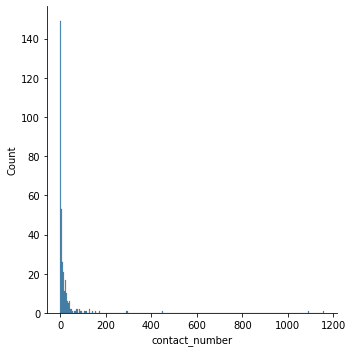

In [84]:
sns.displot(data['contact_number'])
display()

In [85]:
data['contact_number'].describe()

count    332.00
mean      24.27
std       95.07
min        0.00
25%        2.00
50%        5.00
75%       17.25
max     1160.00
Name: contact_number, dtype: float64

contact_number의 분보를 보면, 값을 가진 확진자들 332명은 평균적으로 24명의 사람과 접촉한 것으로 보여집니다. 접촉이 많은 사람은 훨씬 타 사람에 비해 훨씬 많은 접촉을 한 것으로 보입니다.

In [86]:
data[data['contact_number'] == 1160]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
764,1200000031,31.00,female,1959.00,60s,Korea,Daegu,NaN,NaN,Shincheonji Church,nan,nan,1160.00,NaN,2020-02-18,NaN,NaN,isolated,group,11.00,5.00


코로나 바이러스 확산 초창기 확진자 수를 기하급수적으로 늘리는데 기여한 기여한 사람이 '31번 확진자' 임을 볼 수 있습니다.

극단적 값을 갖는 확진자들을 outlier로 봐야하는지에 조심스러운 해석이 필요합니다. 특히나 이번 분석의 주요 특성 중 하나인 '감염경로'에 '집단감염'이 있고, 극단적인 접촉 정도를 가진 확진자는 집단감염의 사례였을 가능성이 높습니다. 또는 극단적 값을 가진 사례가 '개인감염' 이라면, 이는 집단감염과 구분지을 수 있는 척도가 됩니다. 따라서 contact_number의 값을 모두 활용하도록 합니다.

다만 그 값을 갖지 않는 사람들은 위의 '유동성'과 마찬가지로 '접촉이 없었다'고 확신할 근거가 없습니다. 따라서 접촉 횟수 값이 없는 사람들은 제거합니다.

In [87]:
print('original data shape : ', data.shape)
data = data[data['contact_number'].notna()]
print('removed data shape : ', data.shape)

original data shape :  (1204, 21)
removed data shape :  (332, 21)


현재까지 데이터에 남은 확진자는 총 332명 입니다.

### 1-5. Diagnosis time

확진받기까지 걸린 시간이란 증상이 처음 발현되고 얼마나 빨리 코로나19 확진을 받았는지를 의미합니다. 확진을 받기까지 걸린 시간은 사람의 선택/행동에 따라 값이 달라질 수 있는 특성이기 때문에 행동 특성이라고 볼 수 있습니다. 예를들어 진단 검사를 얼마나 신속하게 받으러 갔는지, 코로나 진단 검사 의료진이 코로나 바이러스의 가능성을 얼마나 빨리 발견해 얼마나 신속하게 검사를 받게 했는지에 따라 그 값이 달라질 수 있습니다. 확진받기까지 걸린 시간은 ‘증상이 처음 시작된 날(symptom_onset_date)’과 ‘확진 날짜(confirmed_date)’ 사이의 차이로 정의됩니다.

먼저 활용할 변수의 결측치를 확인합니다.

In [88]:
print('data shape:', data.shape)
print('missing values in symptom_onset_date:', data[data['symptom_onset_date'].isna()].shape)
print('missing values in confirmed_date:', data[data['confirmed_date'].isna()].shape)

data shape: (332, 21)
missing values in symptom_onset_date: (208, 21)
missing values in confirmed_date: (0, 21)


총 332명의 확진자 중, 증상이 발현한 날짜(symptom_onset_date)에 208개의 결측치가 존재합니다. 코로나19는 다른 바이러스와 달리 바이러스를 보유하고 있더라도 증상을 보이지 않을 수 있는 것으로 유명합니다. 따라서 symptom_onset_date가 결측치인 경우, 증상이 나타나지 않았기 때문에 결측치로 기록되었을 가능성이 있습니다. 이 경우 확진받기까지 걸린 시간은 0으로 상정하고 증상이 나타난 직후 확진을 받았다고 가정할 수도 있습니다. 하지만 결측치 중에 증상이 나타났으나 기록이 없는 경우도 배제할 수는 없습니다. 안타깝게도 여기에서 더 나아갈 데이터와 근거가 부족합니다. 이에따라 증상이 발현한 날짜의 정보가 없는 확진자들은 모두 제거합니다.

In [89]:
data[data['symptom_onset_date'] == '']
data['symptom_onset_date'] = np.where((data['symptom_onset_date'] == ''), None, data['symptom_onset_date'])

In [90]:
print('original data shape : ', data.shape)
data = data[data['symptom_onset_date'].notna()]
print('removed data shape : ', data.shape)

original data shape :  (332, 21)
removed data shape :  (124, 21)


결측치 208개가 모두 제거되어 데이터에는 124명의 확진자가 남았습니다. 이들을 대상으로 확진받기까지의 시간을 구할 수 있도록 두 변수를 date format으로 변환하여줍니다.

In [91]:
def date_convert(x):
  x= pd.datetime.strptime(x, '%Y-%m-%d').date()
  return x

In [92]:
data['symptom_onset_date'] = data['symptom_onset_date'].apply(lambda x: date_convert(x))
data['confirmed_date'] = data['confirmed_date'].apply(lambda x: date_convert(x))
data.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00
13,1000000014,30.00,female,1952.00,60s,Korea,Seoul,Jongno-gu,NaN,contact with patient,5.00,1000000013.00,27.00,2020-02-06,2020-02-16,2020-03-12,NaN,released,individual,10.00,3.00
14,1000000015,40.00,male,1943.00,70s,Korea,Seoul,Seongdong-gu,NaN,Seongdong-gu APT,nan,nan,8.00,2020-02-11,2020-02-19,NaN,NaN,isolated,group,6.00,3.00
301,1000000302,8669.00,male,2009.00,10s,Korea,Seoul,Dongjak-gu,NaN,overseas inflow,nan,nan,8.00,2020-03-19,2020-03-20,NaN,NaN,released,overseas,1.00,0.00


date format으로 변환된 symptom_onset_date와 confirmed_date 사이의 날짜 차이를 구해줍니다. 일단 날짜 차이(e.g. 10 days)를 구하고 나면, date format은 그 자체로는 모델에 활용할 수 없기 때문에 모델에서 활용할 수 있도록 integer로 다시 변환하여 마지막 변환된 값을 'days'라는 이름으로 저장합니다.

In [93]:
data['days_notice'] = data['confirmed_date'] - data['symptom_onset_date']
data['hours_notice'] = data['days_notice'].apply(lambda x: round(x.total_seconds()/3600, 2))
data['days'] = data['hours_notice'].apply(lambda x: int(x/24))
data.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential,days_notice,hours_notice,days
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00,1 days,24.00,1
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00,4 days,96.00,4
13,1000000014,30.00,female,1952.00,60s,Korea,Seoul,Jongno-gu,NaN,contact with patient,5.00,1000000013.00,27.00,2020-02-06,2020-02-16,2020-03-12,NaN,released,individual,10.00,3.00,10 days,240.00,10
14,1000000015,40.00,male,1943.00,70s,Korea,Seoul,Seongdong-gu,NaN,Seongdong-gu APT,nan,nan,8.00,2020-02-11,2020-02-19,NaN,NaN,isolated,group,6.00,3.00,8 days,192.00,8
301,1000000302,8669.00,male,2009.00,10s,Korea,Seoul,Dongjak-gu,NaN,overseas inflow,nan,nan,8.00,2020-03-19,2020-03-20,NaN,NaN,released,overseas,1.00,0.00,1 days,24.00,1


이상으로 모델에 활용할 네 가지의 행동 특성 1) 감염 경로 유형, 2) 유동성, 3) 접촉 정도, 4) 확진받기까지 걸린 시간의 제작을 모두 완료하였습니다.

## 2. Building cluster model

### 2-1. Feature transformation

우선 전체 데이터셋에서 위에서 제작한 행동 특성들을 추출해 모델에 활용합니다.

In [94]:
data_ = data[['patient_id', 'days', 'contact_number', 'essential', 'non-essential', 'infection']]
data_.reset_index(drop = True, inplace = True)
print(data_.shape)
data_.head()

(124, 6)


,patient_id,days,contact_number,essential,non-essential,infection
0,1000000001,1,75.00,1.00,1.00,overseas
1,1000000004,4,9.00,1.00,0.00,overseas
2,1000000014,10,27.00,10.00,3.00,individual
3,1000000015,8,8.00,6.00,3.00,group
4,1000000302,1,8.00,1.00,0.00,overseas


#### 2-1-1. transformation of categorical variable

유동성 특성(essential/non-essential)과 확진받기까지 걸린 시간(days), 접촉 정도(contact_number)는 numeric 변수이지만 감염 경로 유형은 categorical 변수인 것을 볼 수 있습니다. 이를 OneHotEncoder를 활용하여 numeric 변수로 변환하고 모델에 활용합니다.

In [95]:
encoder = OneHotEncoder(categories='auto', sparse=False)
encoder.fit(np.array(data_['infection']).reshape(-1, 1))
inf_dummies = encoder.transform(np.array(data_['infection']).reshape(-1,1))
dummies = pd.DataFrame(inf_dummies.astype(int), columns=['infection_'+ x for x in encoder.categories_[0]])

In [96]:
data_ = data_.join(dummies)
print(data_.shape)
data_.head()

(124, 10)


,patient_id,days,contact_number,essential,non-essential,infection,infection_group,infection_individual,infection_overseas,infection_unknown
0,1000000001,1,75.00,1.00,1.00,overseas,0,0,1,0
1,1000000004,4,9.00,1.00,0.00,overseas,0,0,1,0
2,1000000014,10,27.00,10.00,3.00,individual,0,1,0,0
3,1000000015,8,8.00,6.00,3.00,group,1,0,0,0
4,1000000302,1,8.00,1.00,0.00,overseas,0,0,1,0


#### 2-1-2. scaling

데이터 셋이는 모두 numeric 변수들만 존재합니다. 이들 값의 범위가 모두 다르므로 scaler를 활용하여 scaling을 진행합니다. 여기서 활요하는 scaler는 StandardScaler이며, 모델에 활용할 수 있도록 array format으로 변경합니다.

In [97]:
inputs = ['days', 'essential', 'non-essential', 'contact_number', 'infection_group', 'infection_individual', 'infection_overseas', 'infection_unknown']

X = data_[inputs]
print(X.shape)
X.head()

(124, 8)


,days,essential,non-essential,contact_number,infection_group,infection_individual,infection_overseas,infection_unknown
0,1,1.00,1.00,75.00,0,0,1,0
1,4,1.00,0.00,9.00,0,0,1,0
2,10,10.00,3.00,27.00,0,1,0,0
3,8,6.00,3.00,8.00,1,0,0,0
4,1,1.00,0.00,8.00,0,0,1,0


In [98]:
X = X.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

모델에 활용할 inputs을 생성합니다. 생성된 inputs을 PCA 모델을 활용, 모든 features를 2 dimensions로 압축하여 행동 특성에 따른 확진자들의 포인트가 어떻게 분포하는지 살펴보겠습니다.

### 2-2. Dimensionality reduction using PCA

In [100]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDF = pd.DataFrame(data = principalComponents, columns=['PC1', 'PC2'])

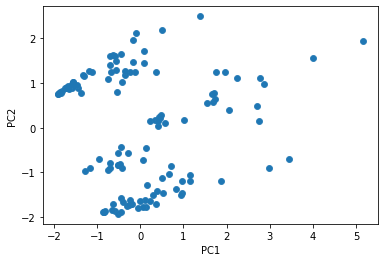

In [101]:
ax = sns.scatterplot(x='PC1',y='PC2', data=principalDF)
sns.regplot(x=principalDF['PC1'], y=principalDF['PC2'], fit_reg=False)
display()

위의 PCA 차트를 보면 3-4개의 clusters가 파악될 것을 예상할 수 있습니다.

### 2-3. Clustering

가장 optimal한 clusters의 개수를 확인하기 위해 각 cluster 개수 별 squared error를 구합니다.

In [103]:
cluster_range = range(1,7)
cluster_errors = []
for n in cluster_range:
  cluster = KMeans(n)
  cluster.fit(X)
  cluster_errors.append(cluster.inertia_)

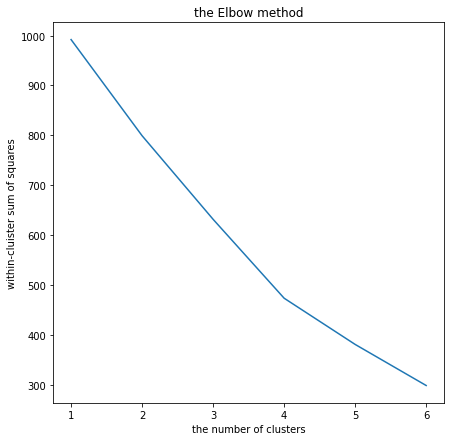

In [104]:
plt.figure(figsize=(7,7))
plt.plot(cluster_range, cluster_errors)
plt.title('the Elbow method')
plt.xlabel('the number of clusters')
plt.ylabel('within-cluister sum of squares')
display()

위의 차트를 보면, cluster의 개수가 4개 이상일 때 에러가 감소하는 폭이 줄어든 것을 확인할 수 있습니다. 이에따라 4를 optimal number of clusters로 결정하고 그대로 cluster 분석을 수행할 수도 있습니다. 하지만 여기서는 4개 이상일 때 어떤 현상이 나타나는지 먼저 확인해보도록 하겠습니다.

In [105]:
km = KMeans(n_clusters=5)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [106]:
centroids = km.cluster_centers_
labels = km.labels_
data_['label'] = labels

분석 결과를 위의 PCA 차트와 겹쳐서 확인합니다.

In [107]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDF = pd.DataFrame(data = principalComponents, columns=['PC1','PC2'])

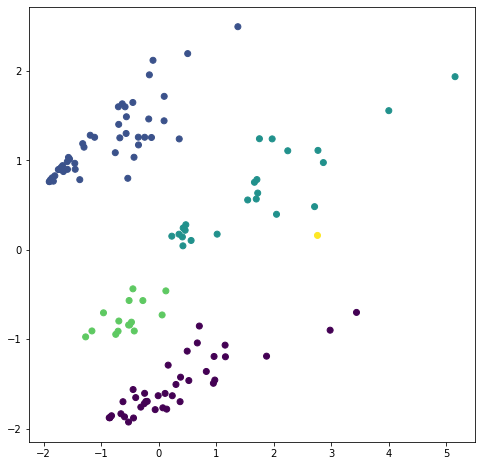

In [108]:
plt.figure(figsize=(8,8))
plt.scatter('PC1','PC2', data=principalDF, c=labels)
display()

위의 결과를 보면 나머지 네 개의 clusters는 근처에 위치한 포인트들이 그룹지어진 반면, 한 개의 포인트만 구분한 cluster가 있는 것을 볼 수 있습니다. 이 포인트는 다른 네 개의 clusters와 행동 패턴을 공유하지 않기 때문에 따로 분류되지만, 하나의 포인트만 속해 cluster라고 보기는 어렵습니다. 그보다는 다른 clusters와 행동 패턴을 공유하지 않는 outlier라고 봐야할 것입니다. 따라서 위의 포인트를 찾아내 제거하고, 4개를 optimal number of cluster로 모델을 다시 돌려보겠습니다.

In [109]:
data_.groupby(['label'])['patient_id'].count()

label
0    39
1    46
2    23
3    15
4     1
Name: patient_id, dtype: int64

In [111]:
data_[data_['label']==4]

,patient_id,days,contact_number,essential,non-essential,infection,infection_group,infection_individual,infection_overseas,infection_unknown,label
62,1300000001,7,450.00,7.00,1.00,overseas,0,0,1,0,4


In [112]:
data_ = data_[data_['patient_id'] != 1300000001]
data_.reset_index(drop=True, inplace=True)

In [113]:
X = data_[inputs]
print('X shape : ', X.shape)

X shape :  (123, 8)


In [114]:
X = X.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [115]:
km = KMeans(n_clusters=4)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [116]:
centroids = km.cluster_centers_
labels = km.labels_
data_['label'] = labels

In [117]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDF = pd.DataFrame(data=principalComponents, columns = ['PC1','PC2'])

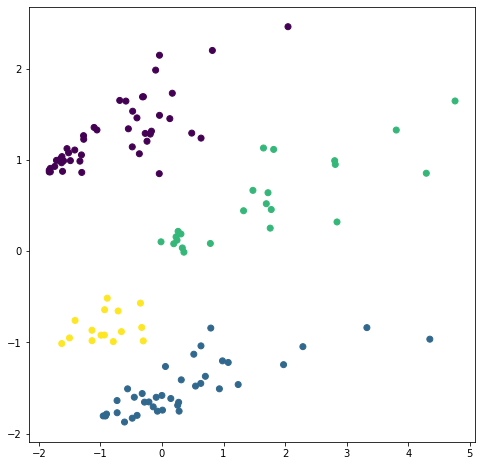

In [118]:
plt.figure(figsize=(8,8))
plt.scatter('PC1','PC2', data=principalDF, c=labels)
display()

Cluter 분석 결과, 행동 패턴으로 구분되는 확진자들의 유형 네 가지 가 파악되었습니다.